In [25]:
C# %cd ../

In [26]:
import os

import pandas as pd
import pandas_datareader.data as web  # For reading stock data from yahoo


class Collector:
    def __init__(self, ticker, start, end, data_path):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.data_path = data_path

    def fetch(self):
        data = web.DataReader(self.ticker, 'yahoo', self.start, self.end)
        # data.reset_index(inplace=True)
        data.to_csv(self.data_path)

        return data

    def get_historical(self):
        if os.path.exists(self.data_path):
            data = pd.read_csv(self.data_path)
            if pd.to_datetime(data['Date'][0]) > pd.to_datetime(self.start):
                data = self.fetch()
        else:
            data = self.fetch()

        return data

In [27]:
start = '2016-01-01'
end = '2021-01-01'
ticker = 'ETH-USD'
data_path = os.path.join('data', f'{ticker}.csv')

collector = Collector(ticker, start, end, data_path)
original_data = collector.get_historical()
data = original_data.copy()


In [33]:
pd.read_csv(data_path, index_col=0)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-01-01,0.954822,0.931442,0.933712,0.948024,2.060620e+05,0.948024
1,2016-01-02,0.969637,0.936560,0.947401,0.937124,2.555040e+05,0.937124
2,2016-01-03,0.991362,0.934313,0.938430,0.971905,4.076320e+05,0.971905
3,2016-01-04,0.976438,0.929835,0.972045,0.954480,3.462450e+05,0.954480
4,2016-01-05,0.970597,0.946543,0.953147,0.950176,2.198330e+05,0.950176
...,...,...,...,...,...,...,...
1820,2020-12-29,737.952881,692.149414,730.358704,731.520142,1.871068e+10,731.520142
1821,2020-12-30,754.303223,720.988892,731.472839,751.618958,1.729457e+10,751.618958
1822,2020-12-31,754.299438,726.511902,751.626648,737.803406,1.392685e+10,737.803406
1823,2021-01-01,749.201843,719.792236,737.708374,730.367554,1.365200e+10,730.367554


In [28]:
data.shape

(1825, 8)

In [29]:
data.head()

,Unnamed: 0,Date,High,Low,Open,Close,Volume,Adj Close
0,0,2016-01-01,0.954822,0.931442,0.933712,0.948024,206062.0,0.948024
1,1,2016-01-02,0.969637,0.936560,0.947401,0.937124,255504.0,0.937124
2,2,2016-01-03,0.991362,0.934313,0.938430,0.971905,407632.0,0.971905
3,3,2016-01-04,0.976438,0.929835,0.972045,0.954480,346245.0,0.954480
4,4,2016-01-05,0.970597,0.946543,0.953147,0.950176,219833.0,0.950176


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2016-01-01 to 2021-01-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1825 non-null   float64
 1   Low        1825 non-null   float64
 2   Open       1825 non-null   float64
 3   Close      1825 non-null   float64
 4   Volume     1825 non-null   float64
 5   Adj Close  1825 non-null   float64
dtypes: float64(6)
memory usage: 99.8 KB


In [ ]:
pd.to_datetime(data['Date'][0])

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
fig = make_subplots(rows = 2, cols = 1, shared_xaxes = True, row_heights = [0.8, 0.2])
price = go.Scatter(x = data['Date'], y = data['Close'], name = ticker.upper())
volume = go.Bar(x = data['Date'], y = data['Volume'], name = 'Volume',
                opacity = 1, marker_line_width = 0)

fig.add_trace(price, row = 1, col = 1)
fig.add_trace(volume, row = 2, col = 1)

fig

In [ ]:
import numpy as np
import pandas as pd
from math import inf
from scipy.signal import argrelextrema

In [ ]:
def find_support(data, price = 'Close', order = 400):
    support_ix =  argrelextrema(data[price].values, np.less_equal, order = order)
    data['Support'] = data.iloc[support_ix][0][price]
    for i in data[data['Support'].notnull()].index:
        for n in range(-int(order/2), int(order/4)+1, 1):
            step = pd.Timedelta(n, unit = 'h')
            if (i - step) < data.index[-1] and (i - step) > data.index[0]:
                data.loc[i - step, 'Support Line'] = data.loc[i, 'Support']


In [ ]:
price = 'Close'
order = 400
support_ix =  argrelextrema(data[price].values, np.less_equal, order = order)
support_ix


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class BaseTrader(BaseEstimator, TransformerMixin):
    def __init__(self, price = 'Close', valid_days = 50, break_support = 0.1, 
                 break_resist = 0.1):
        self.price = price
        self.valid_days = valid_days
        self.break_support = break_support
        self.break_resist = break_resist

    def fit(self, X):
        pass

    def transform(self, X):
        pass
    # ------------- Methods to compute Support and Resistance -------------
    def find_base(self, X, support = True):
        if support:
            base = 'Support'
            func = np.less_equal
        else:
            base = 'Resistance'
            func = np.greater_equal
            
        support_ix =  argrelextrema(X[self.price].values, func,
                                    order = self.valid_days)
        X[base] = X.loc[support_ix, self.price]

        self.find_baseline(X, base)

    def find_baseline(self, X, base):
        X = X.copy()
        line_range = len(X) // 50
        X[f"{base} Line"] = X[base].fillna(method='ffill', limit = line_range)
        X[f"{base} Line"].fillna(method='bfill', limit=line_range, inplace=True)

    def find_support(self, X):
        self.find_base(X, support = True)
    
    def find_resistance(self, X):
        self.find_base(X, support = False)

    # ------------- Methods to derive Buy & Sell Signals -------------

    def buy_signal(self, X):
        ratio = 1 - self.break_support
        X['Signal'] = 0
        mask = X['Support'].notna()
        base =  X['Support'][mask][::-1]
        base_date = list(base.index)
        base = list(base)
        available_base = []
    
    
        for i in range(len(X)):
    
            try:
                if i > base_date[-1]:  # if iterator passes the day of a support
                    available_base.append(base.pop())  # that base becomes available to be compared
                    available_base.sort()
                    base_date.pop()  # pop the base date that have been passed
            except IndexError:
                pass
    
            if len(available_base) > 0:
                if X.loc[i, price] < available_base[-1] * ratio:
                    X.loc[i, 'Signal'] = 1
                    available_base.pop()

In [27]:
transformer = BaseTrader()
transformer.find_base(data)
data.columns


KeyError: "None of [Int64Index([14, 214, 448, 562, 766, 826, 909, 1079, 1133, 1446, 1532], dtype='int64', name='Date')] are in the [index]"

In [53]:
def find_base(data, price = 'Close', duration = 50, support = True):
    if support:
        base = 'Support'
        comparator = np.less_equal
    else:
        base = 'Resistance'
        comparator = np.greater_equal
    support_ix =  argrelextrema(data[price].values, comparator, order = duration)
    data[base] = data.loc[support_ix, price]

    line_range = len(data) // 50
    data[f"{base} Line"] = data[base].fillna(method='ffill', limit = line_range)
    data[f"{base} Line"].fillna(method='bfill', limit=line_range, inplace=True)

In [54]:
find_base(data)

In [49]:
len(data)

1828

In [16]:
pd.set_option('display.max_rows', None)

In [45]:
data['Support'].fillna(method='ffill', limit = 25)

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
5               NaN
6               NaN
7               NaN
8               NaN
9               NaN
10              NaN
11              NaN
12              NaN
13              NaN
14       364.330994
15       364.330994
16       364.330994
17       364.330994
18       364.330994
19       364.330994
20       364.330994
21       364.330994
22       364.330994
23       364.330994
24       364.330994
25       364.330994
26       364.330994
27       364.330994
28       364.330994
29       364.330994
30       364.330994
31       364.330994
32       364.330994
33       364.330994
34       364.330994
35       364.330994
36       364.330994
37       364.330994
38       364.330994
39       364.330994
40              NaN
41              NaN
42              NaN
43              NaN
44              NaN
45              NaN
46              NaN
47              NaN
48              NaN
49              NaN


In [21]:
find_base(data, support=False)

In [22]:
data['Resistance']

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
1823    12254.402344
1824    12254.402344
1825    12254.402344
1826    12254.402344
1827    29374.152344
Name: Resistance, Length: 1828, dtype: float64

In [64]:
data['Support'].loc[(data['Support'].notna()) & (data.index < 250)]

14     364.330994
214    547.465027
Name: Support, dtype: float64

In [69]:
data['Close'][0:1]

0    434.334015
Name: Close, dtype: float64

In [59]:
data.index

RangeIndex(start=0, stop=1828, step=1)

In [24]:
data[data['Close'] < data['Support'] * 0.9]

,Date,Open,High,Low,Close,Adj Close,Volume,Support,Resistance
1053,2018-11-19,5620.779785,5620.779785,4842.910156,4871.490234,4871.490234,7.039560e+09,5903.439941,8424.269531
1054,2018-11-20,4863.930176,4951.609863,4272.109863,4451.870117,4451.870117,8.428290e+09,5903.439941,8424.269531
1055,2018-11-21,4465.540039,4675.729980,4343.979980,4602.169922,4602.169922,6.120120e+09,5903.439941,8424.269531
1056,2018-11-22,4611.569824,4629.640137,4365.640137,4365.939941,4365.939941,4.569370e+09,5903.439941,8424.269531
1057,2018-11-23,4360.700195,4396.419922,4195.680176,4347.109863,4347.109863,4.871490e+09,5903.439941,8424.269531
...,...,...,...,...,...,...,...,...,...
1536,2020-03-16,5385.229492,5385.229492,4575.357910,5014.479980,5014.479980,4.536803e+10,6640.515137,10326.054688
1537,2020-03-17,5002.578125,5371.348633,4981.909180,5225.629395,5225.629395,3.862264e+10,6640.515137,10326.054688
1538,2020-03-18,5227.113770,5331.833984,5069.335938,5238.438477,5238.438477,3.787880e+10,6640.515137,10326.054688
1542,2020-03-22,6185.558105,6359.697266,5823.713867,5830.254883,5830.254883,4.009966e+10,6640.515137,10326.054688


In [70]:
data[price][0]

434.334015

In [78]:
A = np.array([1, 2, 3])
A = np.delete(A, 0)
A

array([2, 3])

In [129]:
def make_buy(data, price = 'Close', penetrate = 0.01):
    ratio = 1 - penetrate
    data['Signal'] = 0
    mask = data['Support'].notna()
    base =  data['Support'][mask][::-1]
    base_date = list(base.index)
    base = list(base)
    available_base = []


    for i in range(len(data)):

        try:
            if i > base_date[-1]:  # if iterator passes the day of a support
                available_base.append(base.pop())  # that base becomes available to be compared
                available_base.sort()
                base_date.pop()  # pop the base date that have been passed
        except IndexError:
            pass

        if len(available_base) > 0:
            if data.loc[i, price] < available_base[-1] * ratio:
                data.loc[i, 'Signal'] = 1
                available_base.pop()


In [18]:
pd.set_option('display.max_rows', 10)

In [130]:
make_buy(data)

[364.330994]
[364.330994, 547.465027]
[364.330994, 547.465027, 937.52002]
[364.330994, 547.465027, 937.52002, 1929.819946]
[364.330994, 547.465027, 937.52002, 1929.819946, 6955.27002]
Base 6955.27002
Buying at 6811.470215
[364.330994, 547.465027, 937.52002, 1929.819946, 6636.319824]
Base 6636.319824
Buying at 6349.899902
[364.330994, 547.465027, 937.52002, 1929.819946, 5903.439941]
Base 5903.439941
Buying at 5738.350098
[364.330994, 547.465027, 937.52002, 1929.819946, 3236.761719]
[364.330994, 547.465027, 937.52002, 1929.819946, 3236.761719, 3399.47168]
[364.330994, 547.465027, 937.52002, 1929.819946, 3236.761719, 3399.47168, 6640.515137]
Base 6640.515137
Buying at 4970.788086


In [107]:
mask = data['Support'].notna()
base = data['Support'][mask][::-1]
base

1446    6640.515137
1133    3399.471680
1079    3236.761719
909     5903.439941
826     6636.319824
766     6955.270020
562     1929.819946
448      937.520020
214      547.465027
14       364.330994
Name: Support, dtype: float64

In [118]:
data[data['Signal'] == 1]

,Date,Open,High,Low,Close,Adj Close,Volume,Support,Support Line,Signal
1,2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600.0,NaN,364.330994,1
2,2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800.0,NaN,364.330994,1
3,2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500.0,NaN,364.330994,1
4,2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600.0,NaN,364.330994,1
5,2016-01-06,431.855988,431.855988,426.341003,429.105011,429.105011,34042500.0,NaN,364.330994,1
6,2016-01-07,430.010986,458.765991,429.076996,458.048004,458.048004,87562200.0,NaN,364.330994,1
7,2016-01-08,457.537994,462.933990,447.937988,453.230011,453.230011,56993000.0,NaN,364.330994,1
8,2016-01-09,453.382996,454.640015,446.889008,447.610992,447.610992,32278000.0,NaN,364.330994,1
9,2016-01-10,448.238007,448.308990,440.351013,447.990997,447.990997,35995900.0,NaN,364.330994,1


In [84]:
ratio = 1 - 0.1
data['Signal'] = 0
mask = data['Support'].notna()
base = list(data['Support'][mask][::-1])
base_date = list(data[mask].index[::-1])

In [85]:
base

[6640.515137,
 3399.47168,
 3236.761719,
 5903.439941,
 6636.319824,
 6955.27002,
 1929.819946,
 937.52002,
 547.465027,
 364.330994]

In [86]:
base_date

[1446, 1133, 1079, 909, 826, 766, 562, 448, 214, 14]

<AxesSubplot:>

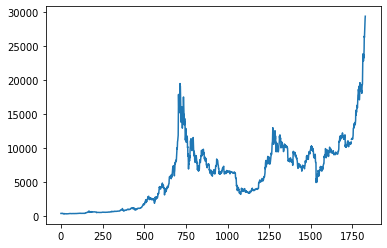

In [87]:
data[price].plot()